In [1]:
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# Loading and Visualizing Data

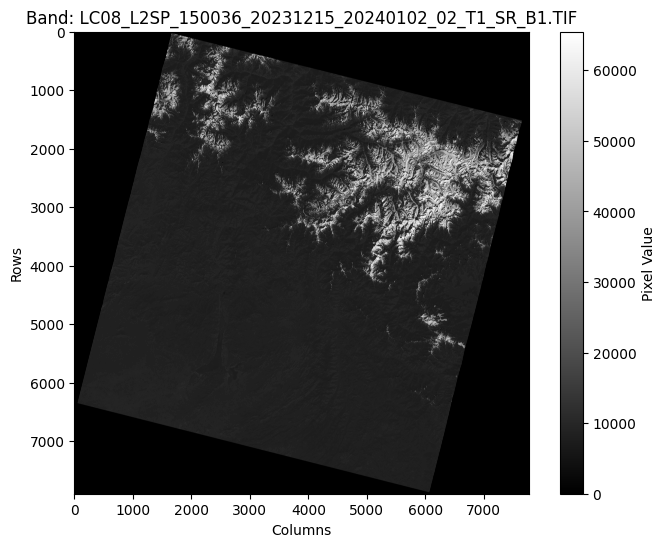

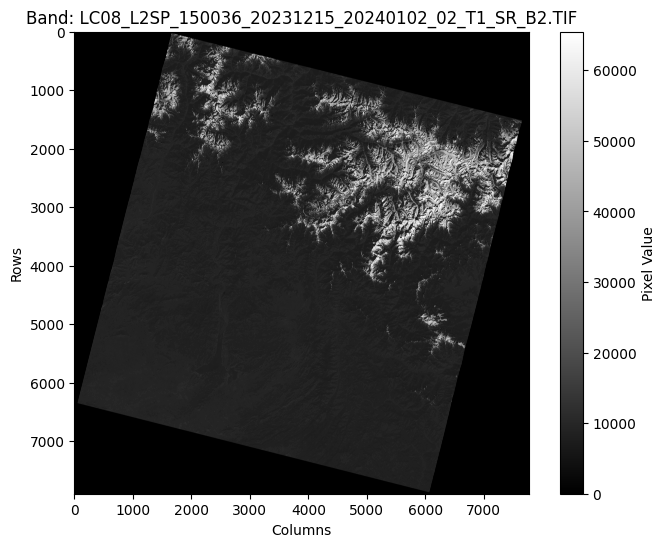

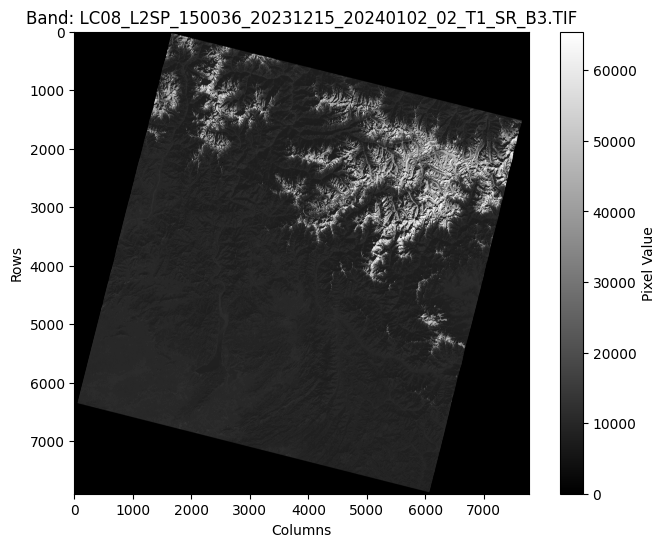

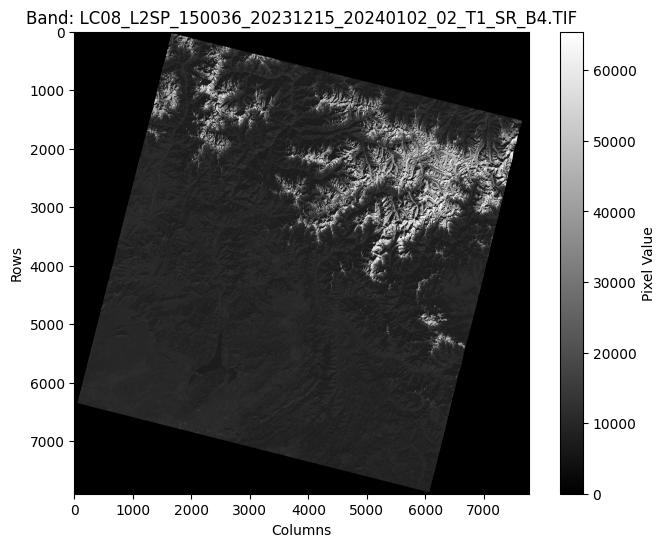

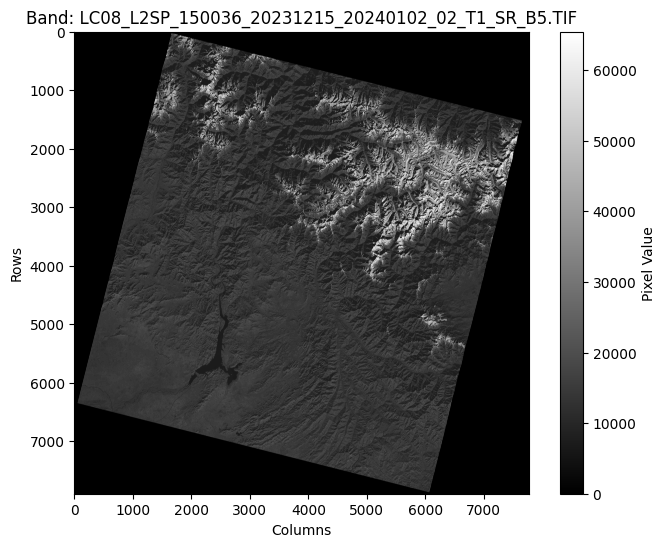

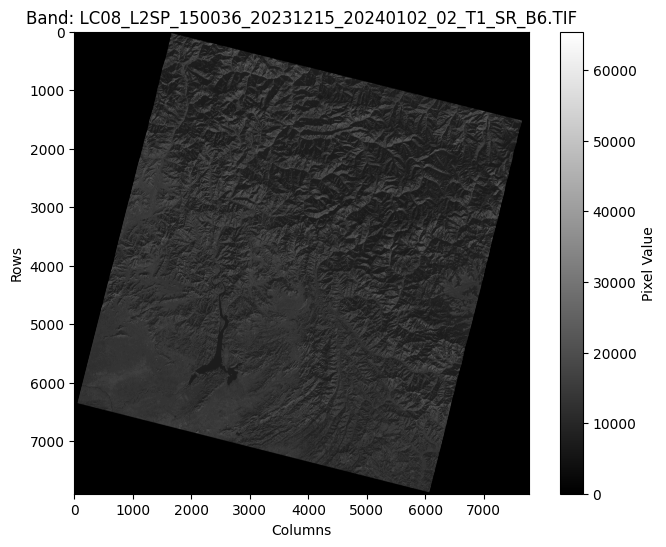

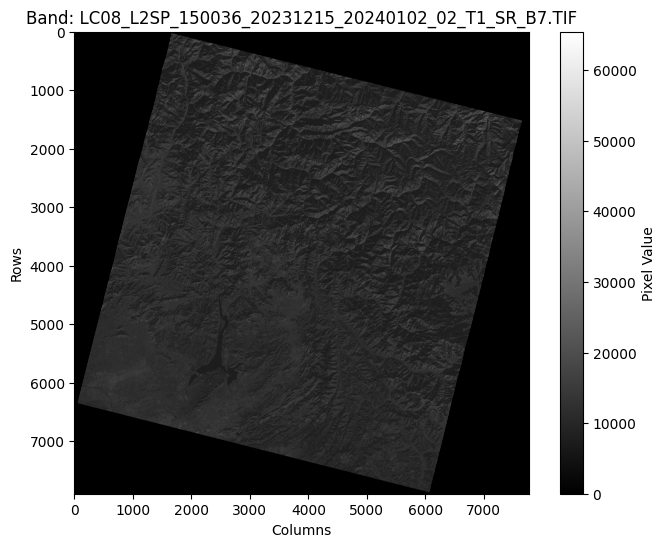

In [2]:
# Define the folder containing the spectral bands
data_dir = Path("/Users/macbookpro/Desktop/7th semester/Linear Algebra-2/project/Code/CEPdata")  # Update with the actual path
example_folder = data_dir / "LC08_L2SP_150036_20231215_20240102_02_T1 (1)"

# Check if the folder exists and contains TIF files
if not example_folder.exists():
    raise FileNotFoundError(f"Directory not found: {example_folder}")
spectral_files = sorted([file for file in example_folder.glob("*.TIF") if "SR_B" in file.name])
if not spectral_files:
    raise FileNotFoundError("No spectral band files found in the specified directory.")

# Function to visualize a band
def visualize_band(band_data, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(band_data, cmap='gray')
    plt.colorbar(label="Pixel Value")
    plt.title(title)
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.show()

# Visualize each band
for file in spectral_files:
    with rasterio.open(file) as dataset:
        band_data = dataset.read(1)  # Read the first layer of the band
        visualize_band(band_data, f"Band: {file.name}")

# Preprocess for PCA

### Cropping the images to desired size

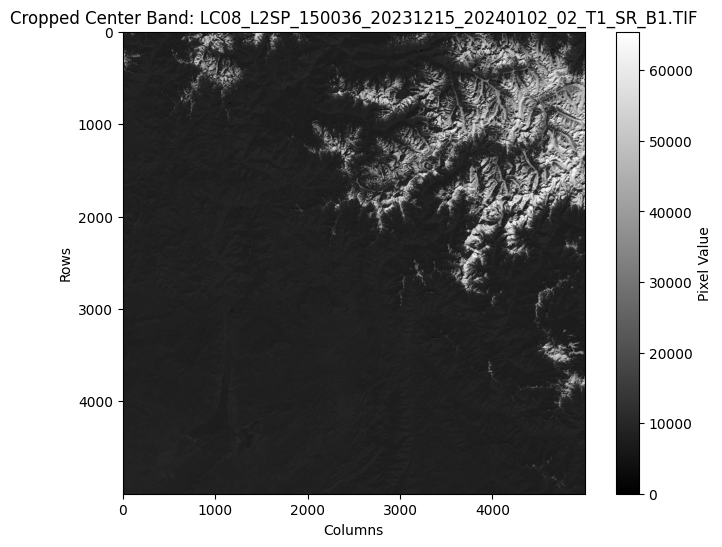

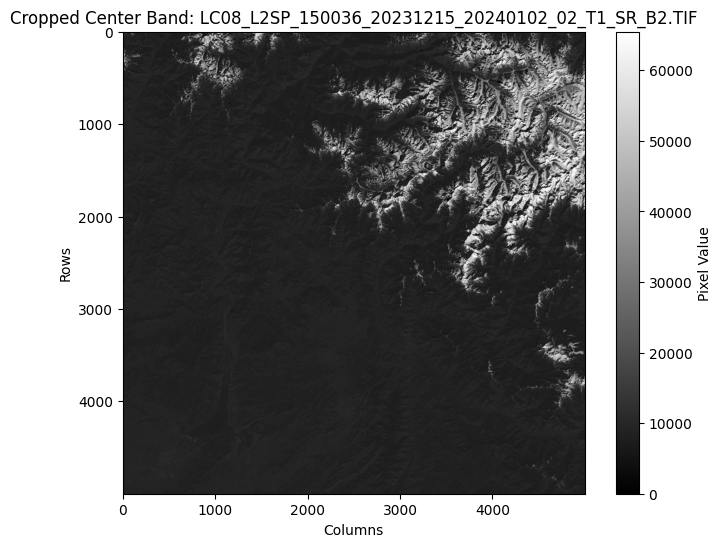

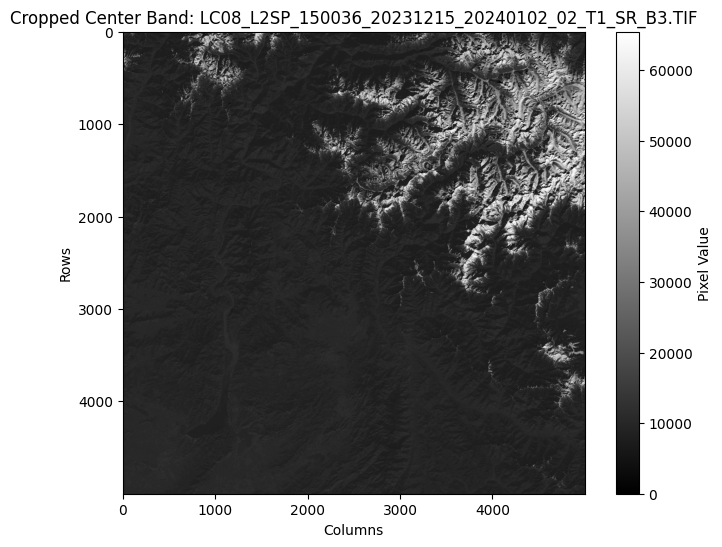

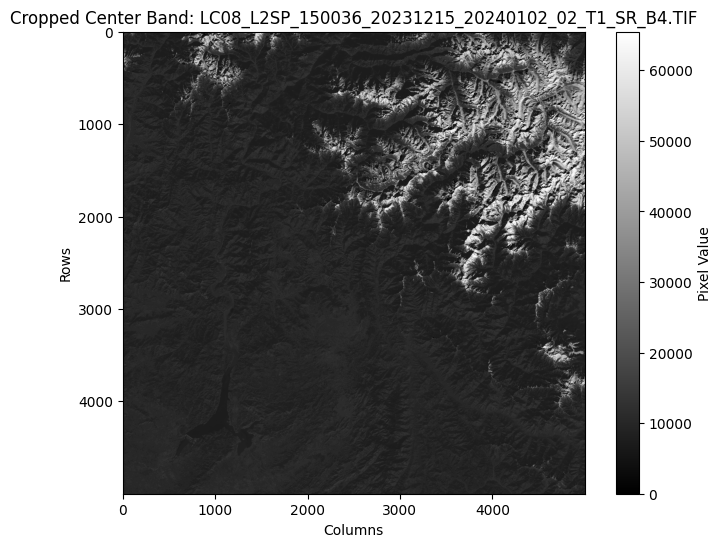

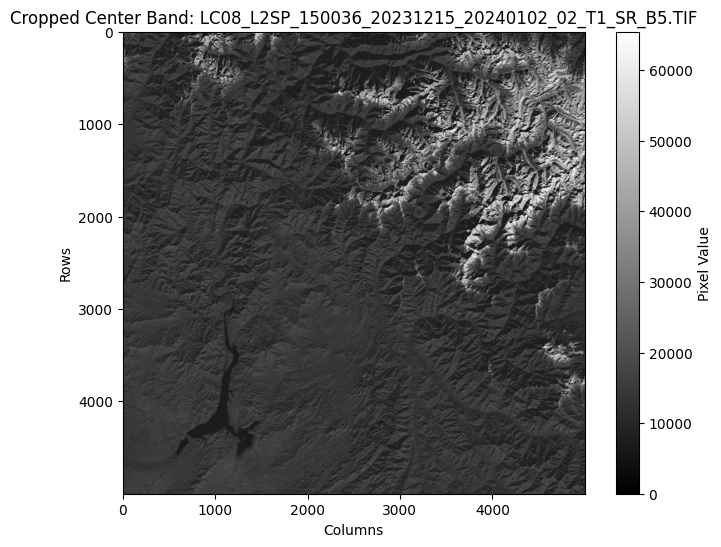

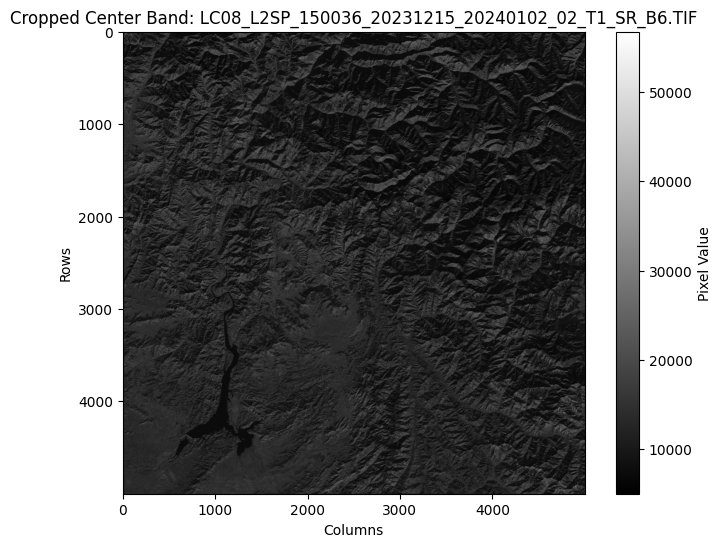

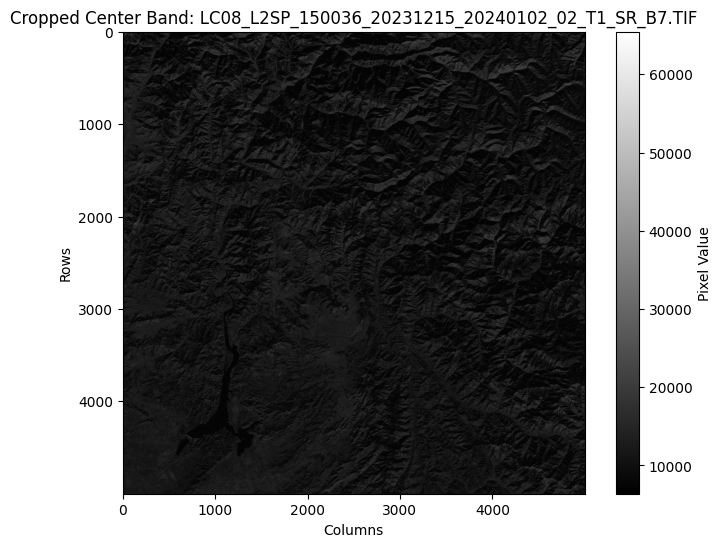

Cropped stack shape: (5000, 5000, 7)


In [3]:
# Define the crop size
crop_size = (5000, 5000)  # Desired crop size (rows, cols)

def center_crop(image, crop_size):
    """
    Crop the center of an image by the specified crop size.
    :param image: 2D NumPy array of the image to crop.
    :param crop_size: Tuple of (crop_height, crop_width).
    :return: Cropped 2D NumPy array.
    """
    rows, cols = image.shape
    crop_rows, crop_cols = crop_size

    # Ensure crop dimensions do not exceed image dimensions
    crop_rows = min(crop_rows, rows)
    crop_cols = min(crop_cols, cols)

    # Calculate the center and crop bounds
    start_row = (rows - crop_rows) // 2
    end_row = start_row + crop_rows
    start_col = (cols - crop_cols) // 2
    end_col = start_col + crop_cols

    return image[start_row:end_row, start_col:end_col]

# Apply center cropping to all bands
cropped_bands = []

for file in spectral_files:
    try:
        with rasterio.open(file) as dataset:
            band_data = dataset.read(1)
            # Perform center cropping
            cropped_band = center_crop(band_data, crop_size)
            cropped_bands.append(cropped_band)

            # Visualize the cropped band
            plt.figure(figsize=(8, 6))
            plt.imshow(cropped_band, cmap='gray')
            plt.colorbar(label="Pixel Value")
            plt.title(f"Cropped Center Band: {file.name}")
            plt.xlabel("Columns")
            plt.ylabel("Rows")
            plt.show()
    except Exception as e:
        print(f"Error processing file {file.name}: {e}")

# Stack cropped bands for further processing (3D array: rows x cols x bands)
cropped_stack = np.stack(cropped_bands, axis=-1)  # Shape: (crop_rows, crop_cols, num_bands)
print(f"Cropped stack shape: {cropped_stack.shape}")


# Flatten the Stacked Data
PCA works on 2D data where each row is a sample, and each column is a feature (band). Flatten the spatial dimensions (rows × cols) into a single dimension.

In [4]:
# Step 1: Flatten the data (pixels, bands)
rows, cols, bands = cropped_stack.shape
flattened_data = cropped_stack.reshape(-1, bands)  # Shape: (pixels, bands)
print(f"Flattened data shape: {flattened_data.shape}")



Flattened data shape: (25000000, 7)


# Standardizing Data for PCA

In [5]:
from sklearn.preprocessing import StandardScaler

# Step 2: Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(flattened_data)  # Zero mean and unit variance


# Centering the Data for PCA

In [6]:
# Step 3: Center the data
mean_vector = np.mean(standardized_data, axis=0)  # Mean of each band
centered_data = standardized_data - mean_vector  # Subtract the mean from each band

# Computing Covariance Matrix

In [7]:
# Step 4: Compute the covariance matrix
covariance_matrix = np.cov(centered_data, rowvar=False)  # Shape: (bands, bands)
print(f"Covariance matrix shape: {covariance_matrix.shape}")

Covariance matrix shape: (7, 7)


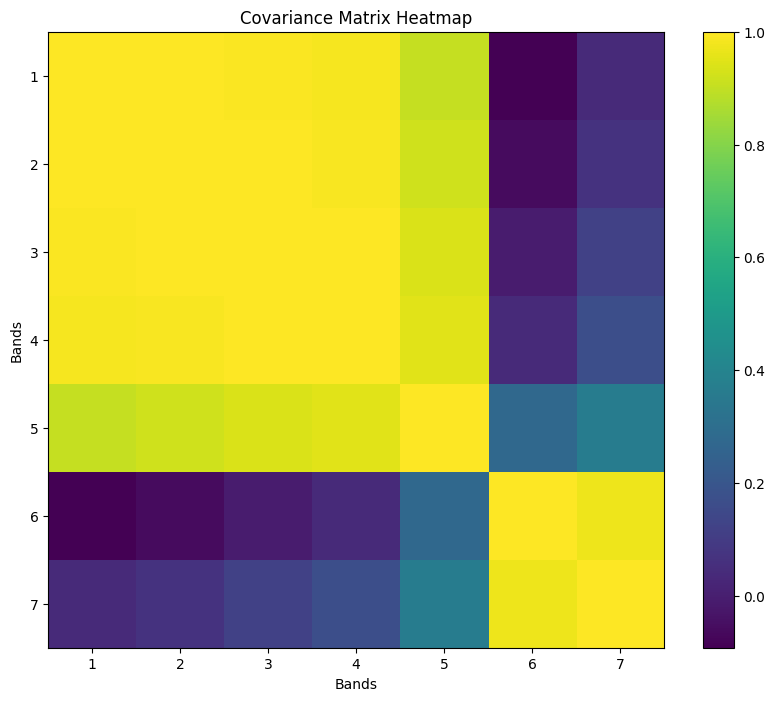

In [8]:
# Plotting the covariance matrix
plt.figure(figsize=(10, 8))
plt.imshow(covariance_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Covariance Matrix Heatmap')
plt.xlabel('Bands')
plt.ylabel('Bands')
plt.xticks(ticks=np.arange(covariance_matrix.shape[1]), labels=np.arange(1, covariance_matrix.shape[1] + 1))
plt.yticks(ticks=np.arange(covariance_matrix.shape[0]), labels=np.arange(1, covariance_matrix.shape[0] + 1))
plt.show()

# Computing Eigenvalues and Eigenvectors
The eigenvalues determine the variance captured by each principal component, and the eigenvectors define the directions.

In [9]:
# Step 5: Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Step 6: Sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

print("Eigenvalues and eigenvectors computed.")

Eigenvalues and eigenvectors computed.


# Select Number of Principal Components
Choose k principal components based on explained variance (eigenvalues).

For 90.0% variance, number of components: 2
Variance Threshold: 90.0%
Number of Components: 2
MSE: 618638.5408959314
RMSE: 786.5357848794494
PSNR: 38.40448681536922 dB

For 95.0% variance, number of components: 2
Variance Threshold: 95.0%
Number of Components: 2
MSE: 618638.5408959314
RMSE: 786.5357848794494
PSNR: 38.40448681536922 dB

For 98.0% variance, number of components: 2
Variance Threshold: 98.0%
Number of Components: 2
MSE: 618638.5408959314
RMSE: 786.5357848794494
PSNR: 38.40448681536922 dB



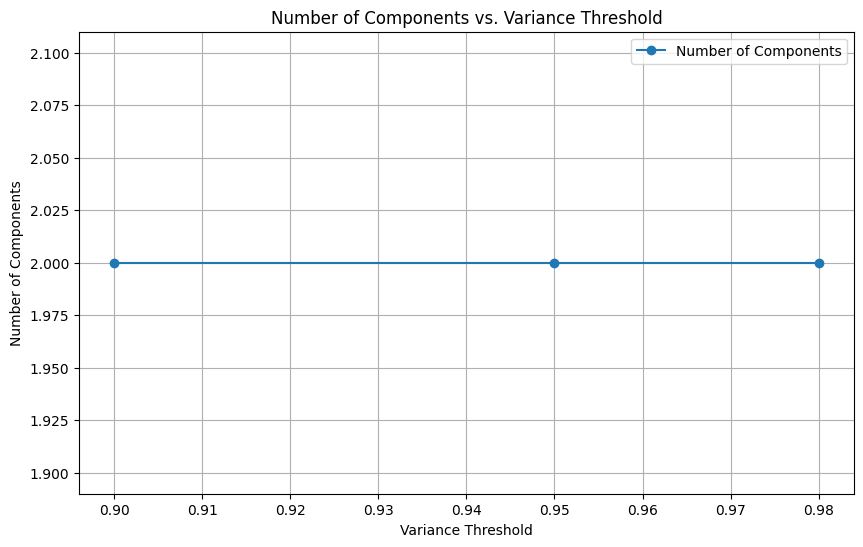

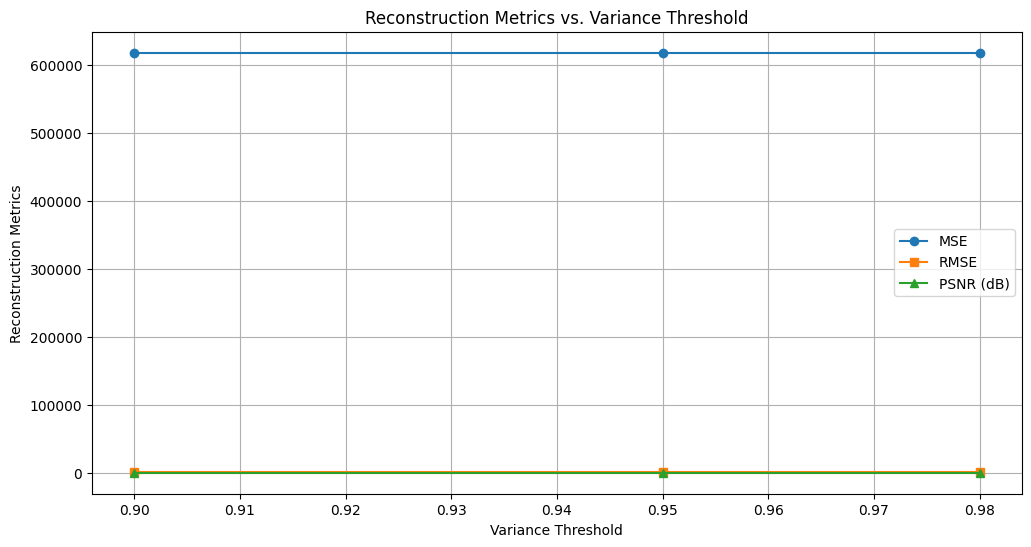

In [10]:
# Step 7: Experiment with variance thresholds
variance_thresholds = [0.90, 0.95, 0.98]  # List of thresholds to test
rows, cols, bands = cropped_stack.shape
results = []

explained_variance_ratio = sorted_eigenvalues / np.sum(sorted_eigenvalues)
cumulative_variance = np.cumsum(explained_variance_ratio)

for threshold in variance_thresholds:
    # Compute cumulative variance and number of components
    k = np.argmax(cumulative_variance >= threshold) + 1
    print(f"For {threshold*100}% variance, number of components: {k}")
    
    # Select the top-k eigenvectors
    principal_components = sorted_eigenvectors[:, :k]
    
    # Project data onto selected components
    reduced_data = centered_data @ principal_components
    
    # Reconstruct data from reduced components
    reconstructed_data = reduced_data @ principal_components.T

    # Inverse scaling to original scale
    original_scale_data = scaler.inverse_transform(reconstructed_data)

    # Reshape back to original image dimensions
    reconstructed_image = original_scale_data.reshape(rows, cols, bands)

    # Calculate reconstruction metrics
    mse = np.mean((cropped_stack - reconstructed_image) ** 2)
    rmse = np.sqrt(mse)
    max_pixel_value = np.max(cropped_stack)
    psnr = 20 * np.log10(max_pixel_value / rmse) if rmse != 0 else float('inf')
    
    print(f"Variance Threshold: {threshold*100}%")
    print(f"Number of Components: {k}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"PSNR: {psnr} dB\n")
    
    # Append all metrics to results
    results.append((threshold, k, mse, rmse, psnr))

# Extract results for plotting
    thresholds, components, mse_vals, rmse_vals, psnr_vals = zip(*results)

# Plot Number of Components vs Variance Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, components, marker='o', label='Number of Components')
plt.xlabel('Variance Threshold')
plt.ylabel('Number of Components')
plt.title('Number of Components vs. Variance Threshold')
plt.grid()
plt.legend()
plt.show()

# Plot MSE, RMSE, and PSNR
plt.figure(figsize=(12, 6))
plt.plot(thresholds, mse_vals, marker='o', label='MSE')
plt.plot(thresholds, rmse_vals, marker='s', label='RMSE')
plt.plot(thresholds, psnr_vals, marker='^', label='PSNR (dB)')
plt.xlabel('Variance Threshold')
plt.ylabel('Reconstruction Metrics')
plt.title('Reconstruction Metrics vs. Variance Threshold')
plt.legend()
plt.grid()
plt.show()


# Project Data to Principal Components
Project the normalized data onto the principal components to reduce dimensions.

In [11]:
# Step 8: Project data onto the principal components
reduced_data = centered_data @ principal_components  # Shape: (pixels, k)
print(f"Reduced data shape: {reduced_data.shape}")

Reduced data shape: (25000000, 2)


### Reshape Reduced Data Back to Image

In [12]:
# Step 9: Reshape the reduced data back to image format
reduced_image = reduced_data.reshape(rows, cols, k)  # Shape: (rows, cols, k)
print(f"Reduced data shape: {reduced_image.shape}")

Reduced data shape: (5000, 5000, 2)


# Understanding the Results

### Stacked Data Shape: (5000, 5000, 7)
The original image had 7 spectral bands (features) for each of the 5000 rows and 5000 columns.

### Flattened Data Shape: (25000000, 7)
The spatial dimensions (rows × cols) have been flattened into a single dimension for PCA processing. Each pixel is now a single sample with 7 features.

### Reduced Data Shape: (25000000, 2)
After applying PCA, you've reduced the data to 2 principal components per sample. This means each pixel is now represented by just 2 numbers instead of 7.

### Reduced Image Shape: (5000, 5000, 2)
The reduced data has been reshaped back into image format with 2 layers (corresponding to the 2 principal components).

## Analyze Error and Reconstruct
Reconstruct the original data using the top-k components and calculate the reconstruction error.

In [13]:
# Reconstruct the normalized data
reconstructed_data = reduced_data @ principal_components.T

# Inverse scaling to original scale
original_scale_data = scaler.inverse_transform(reconstructed_data)

# Reshape back to original image dimensions
reconstructed_image = original_scale_data.reshape(rows, cols, bands)

### Error Analysis
Using Mean Squared Error (MSE) to evaluate reconstruction quality.

In [14]:
# Step 11: Error Analysis (MSE, RMSE, PSNR)
# Compute Mean Squared Error
mse = np.mean((cropped_stack - reconstructed_image) ** 2)

# Compute Root Mean Squared Error
rmse = np.sqrt(mse)

# Compute Peak Signal-to-Noise Ratio (PSNR)
max_pixel_value = np.max(cropped_stack)
psnr = 20 * np.log10(max_pixel_value / rmse) if rmse != 0 else float('inf')

# Output error metrics
print("Reconstruction Error Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr} dB")

Reconstruction Error Metrics:
Mean Squared Error (MSE): 618638.5408959314
Root Mean Squared Error (RMSE): 786.5357848794494
Peak Signal-to-Noise Ratio (PSNR): 38.40448681536922 dB


In [15]:
k = 1  # Retain only the top component
principal_components = sorted_eigenvectors[:, :k]

# Project data
reduced_data = centered_data @ principal_components

# Reconstruct data
reconstructed_data = reduced_data @ principal_components.T
original_scale_data = scaler.inverse_transform(reconstructed_data) # Inverse transform before reshaping and calculating error
reconstructed_image = original_scale_data.reshape(rows, cols, bands)  # Assuming rows, cols, bands are defined earlier


# Calculate error metrics
mse = np.mean((cropped_stack - reconstructed_image) ** 2)
rmse = np.sqrt(mse)
max_pixel_value = np.max(cropped_stack)
psnr = 20 * np.log10(max_pixel_value / rmse) if rmse != 0 else float('inf')

print(f"Metrics for k=1: MSE={mse}, RMSE={rmse}, PSNR={psnr}")

Metrics for k=1: MSE=5799494.681109107, RMSE=2408.2140023488582, PSNR=28.684954999276755


## Visualizing the Reduced Image
We can visualize each principal component to understand how much variance they capture.

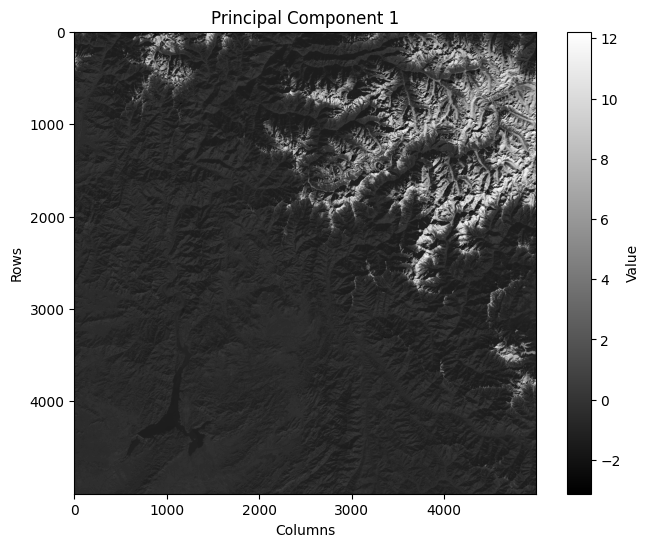

In [16]:
# Step 10: Visualizing the results
for i in range(k):
    plt.figure(figsize=(8, 6))
    plt.imshow(reduced_image[:, :, i], cmap='gray')
    plt.colorbar(label="Value")
    plt.title(f"Principal Component {i + 1}")
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.show()


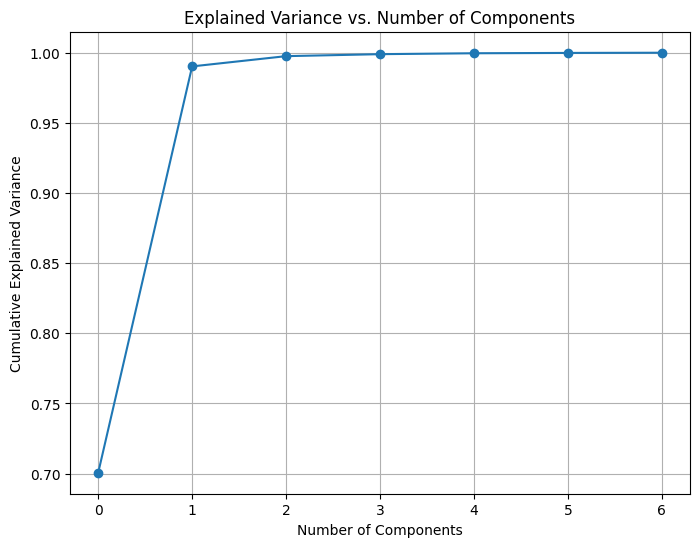

In [17]:
# Plotting cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.grid()
plt.show()